# MS022 Epoching
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS022'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 56 x 1456512 (2844.7 s), ~622.4 MB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1456512 (2844.7 s), ~11.1 MB, data loaded>

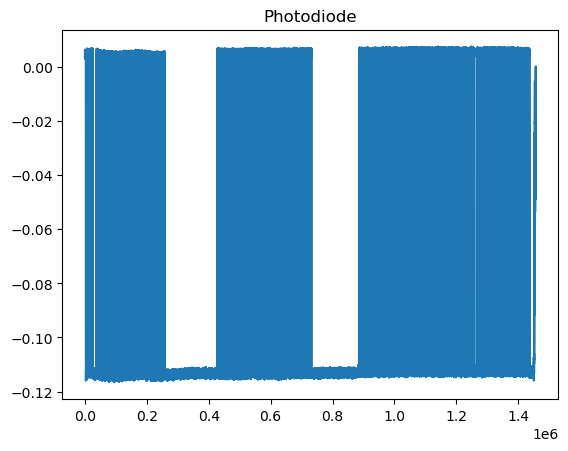

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [8]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-7.998392,33.753014,11.599995,-7.303106,29.507935,-4.544081,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCaS2,Unknown,-11.997591,33.753014,15.199995,-11.263673,31.336920,-0.649451,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,NaN,NaN
2,LaCaS3,Unknown,-15.596870,33.753014,19.199995,-14.826880,33.353221,3.587480,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,NaN,NaN
3,LaCaS4,Unknown,-19.196148,34.551902,21.599995,-18.475267,35.217119,5.812331,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,NaN,NaN
4,LaCaS5,Unknown,-22.395507,34.551902,24.799995,-21.683689,36.761797,9.288654,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,LplfO4,Unknown,-49.590058,-4.194170,19.999995,-47.937431,-2.052692,25.197714,Gray,Left Cerebral White Matter,Unknown,L Precentral Gyrus,Unknown,Unknown,Left posterior motor I,NaN
68,LplfO5,A4hf_L,-54.389097,-3.794726,21.599995,-52.836611,-1.118054,26.762258,Gray,Left Cerebral White Matter,Unknown,L Precentral Gyrus,L PrG,Left posterior motor I,NaN,NaN
69,LplfO6,A4hf_L,-59.987975,-2.995838,23.599995,-58.569705,0.138888,28.441652,Gray,Left PrG precentral gyrus,Unknown,L Precentral Gyrus,L PrG,Left posterior motor I,NaN,NaN
70,uLaCaS,A32sg_L,-5.598873,34.152458,9.999995,-5.000333,29.004945,-6.416785,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN


## Load behavior

In [9]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,92.0,gain,430.604925,430.607623,434.053213,436.070125,3.445590,0.6,0.00,...,0.000000,0.679661,0.320339,-0.590042,-0.590042,-0.374739,-0.590042,-0.374739,0.000000,0.000000
1,2,113.0,loss,441.014521,441.015492,445.880849,447.896615,4.865357,-0.3,-0.60,...,-0.019136,0.492111,0.507889,0.019136,0.000000,0.010104,0.000000,0.000000,0.019136,0.010104
2,3,87.0,gain,452.429016,452.439431,455.575694,457.591840,3.136263,0.5,0.00,...,0.000000,0.963899,0.036101,-1.204146,-1.204146,-0.263989,-1.204146,-0.263989,0.000000,0.000000
3,4,77.0,gain,472.966682,472.967658,477.863903,477.871546,4.896245,0.4,0.00,...,0.000000,0.893092,0.106908,0.000000,-0.607578,-0.607578,-0.607578,-0.607578,0.000000,0.000000
4,5,68.0,gain,484.495504,484.496259,487.725311,489.741359,3.229052,0.3,0.00,...,0.000000,0.842857,0.157143,0.000000,0.000000,0.480758,0.000000,0.000000,0.579685,0.480758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,122.0,loss,3092.517436,3092.525352,3098.422866,3100.439126,5.897514,-0.4,-0.73,...,-0.027894,0.490975,0.509025,0.000000,-0.027894,-0.010334,-0.027894,-0.010334,0.000000,0.000000
146,147,30.0,mix,3105.397980,3105.406597,3112.165066,3112.172339,6.758469,0.0,-1.50,...,-0.111297,0.566056,0.433944,0.000000,0.111297,0.111297,0.000000,0.000000,0.111297,0.111297
147,148,51.0,gain,3126.175598,3126.184267,3130.622572,3132.638438,4.438305,0.2,0.00,...,0.000000,0.515299,0.484701,-0.062912,-0.062912,-0.045391,-0.062912,-0.045391,0.000000,0.000000
148,149,98.0,gain,3138.090275,3138.090982,3143.048507,3145.064878,4.957525,0.6,0.00,...,0.000000,0.998278,0.001722,-2.195864,-2.195864,-0.374739,-2.195864,-0.374739,0.000000,0.000000


In [10]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [11]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.5)

10 blocks
..........

found matches for 120 of 158 pulses


In [12]:
print(slope, offset)

0.9999864132331301 -357.735542727758


## Make epochs

In [13]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [14]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [15]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [16]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=1, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 8316 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 8400 out of 8400 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 8332 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 8400 out of 8400 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks     

In [17]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~98.6 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~164.2 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [18]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [19]:
epochs_all_evs[event].metadata

,lmolf6,lmcms6,lplfo3,lpcsma10,laglt5,lhplt6,lhplt12,llesion7,llesion8,lacas1-lacas5,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,[943],NaN,NaN,NaN,...,0.545,-0.545,-1.09,-0.60,-1.09,-0.60,0.00,0.00,0.590042,0.374739
1,NaN,NaN,NaN,NaN,NaN,NaN,[793],NaN,NaN,NaN,...,-0.300,0.300,0.00,0.30,0.00,0.00,0.60,0.30,-0.019136,-0.010104
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.790,-0.790,-1.58,-0.50,-1.58,-0.50,0.00,0.00,1.204146,0.263989
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.86,-0.86,-0.86,-0.86,0.00,0.00,0.779519,0.171941
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.540,0.540,0.00,0.78,0.00,0.00,1.08,0.78,0.579685,0.098927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,[2407],NaN,NaN,NaN,...,-0.365,-0.365,-0.73,-0.33,-0.73,-0.33,0.00,0.00,-0.027894,-0.017561
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.60,-0.60,0.00,0.00,1.50,1.50,0.076073,0.000000
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.170,-0.170,-0.34,-0.20,-0.34,-0.20,0.00,0.00,0.062912,0.045391
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.080,-1.080,-2.16,-0.60,-2.16,-0.60,0.00,0.00,2.195864,0.374739


### Save epoched data

In [20]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)